IMPORT DES BIBLIOTHEQUES

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
sys.path.append('..')  # Ajoute le dossier Functions au chemin de recherche
from Functions.ImportData import load_data
from Functions.features_engineering import extract_dayMonth
from Functions.features_engineering import extract_features
from Functions.models import train_linear_regression
from Functions.xgboost_model import train_xgboost
from Functions.models import train_random_forest
from Functions.Graphique import consommation_moyenne
from Functions.Graphique import plot_consommation_par_annee

IMPORT DES DONNEES 

importation des fichiers csv grâce à la fonction load_data

In [2]:
# Remonter d'un niveau par rapport au répertoire actuel (Notebook)
data_path = os.path.join(os.getcwd(), '..', 'data')

# Convertir le chemin en chemin absolu
data_path = os.path.abspath(data_path)

# Charger les données
data = load_data(data_path)

# Afficher un aperçu des données
data.head(10)


,Nobs,jour,consommation,Année
0,1,2008-01-01,2933570.806,2008
1,2,2008-01-02,3462418.351,2008
2,3,2008-01-03,3587632.181,2008
3,4,2008-01-04,3433062.753,2008
4,5,2008-01-05,3061099.826,2008
5,6,2008-01-06,2801619.562,2008
6,7,2008-01-07,3144017.218,2008
7,8,2008-01-08,3325199.453,2008
8,9,2008-01-09,3311523.485,2008
9,10,2008-01-10,3306639.626,2008


features engineering avec les fonctions extract_dayMonth et extract_features

In [3]:
data = extract_dayMonth(data,'jour')
data.head(10)

,Nobs,jour,consommation,Année,Jour_semaine,Mois,Numero_jour,Annee
0,1,2008-01-01,2933570.806,2008,1,1,1,2008
1,2,2008-01-02,3462418.351,2008,2,1,2,2008
2,3,2008-01-03,3587632.181,2008,3,1,3,2008
3,4,2008-01-04,3433062.753,2008,4,1,4,2008
4,5,2008-01-05,3061099.826,2008,5,1,5,2008
5,6,2008-01-06,2801619.562,2008,6,1,6,2008
6,7,2008-01-07,3144017.218,2008,0,1,7,2008
7,8,2008-01-08,3325199.453,2008,1,1,8,2008
8,9,2008-01-09,3311523.485,2008,2,1,9,2008
9,10,2008-01-10,3306639.626,2008,3,1,10,2008


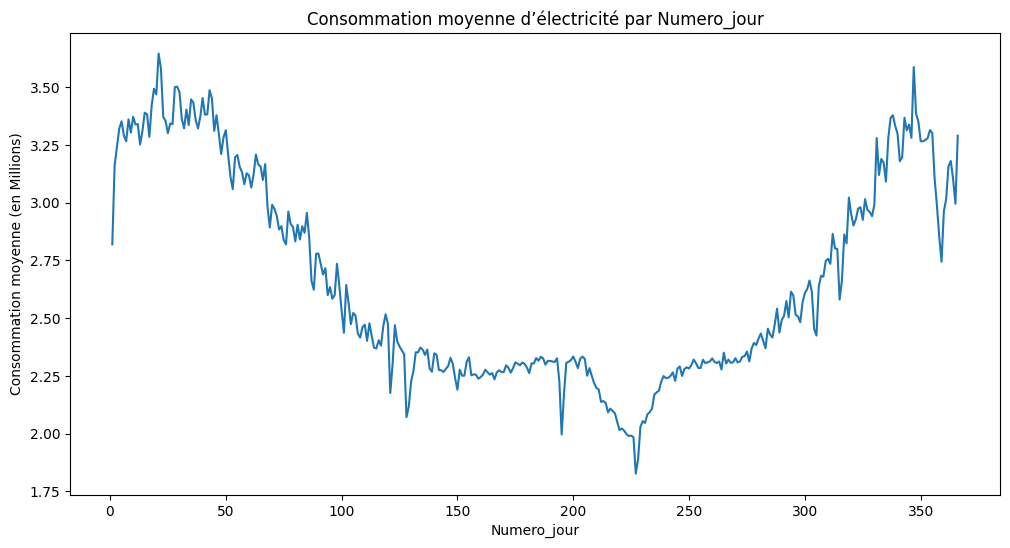

In [4]:
consommation_moyenne(data,"Numero_jour")

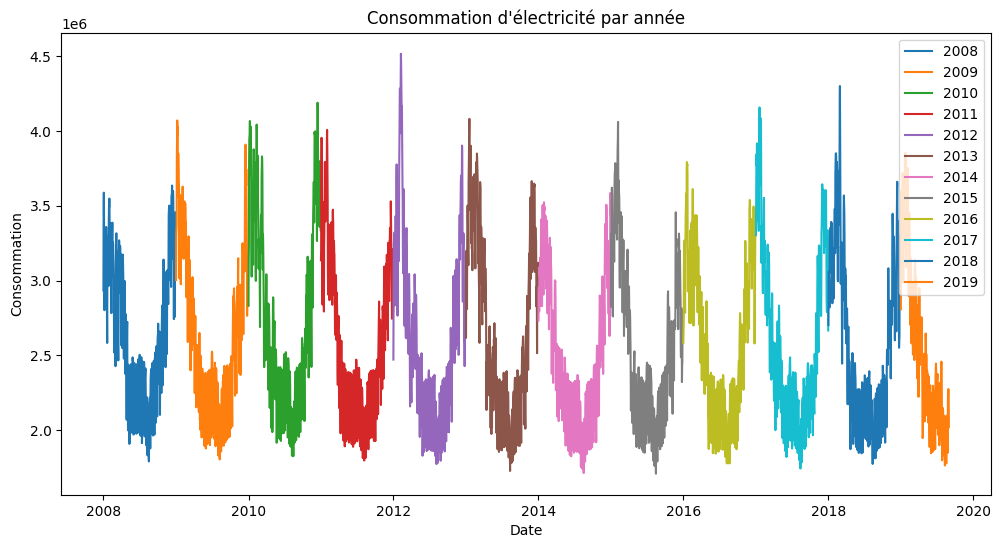

In [5]:
plot_consommation_par_annee(data)

In [6]:
data = extract_features(data)
data.head(10)

,Nobs,jour,consommation,Année,Annee,sin_jour_annee,cos_jour_annee,sin_jour,cos_jour,sin_mois,cos_mois
0,1,2008-01-01,2933570.81,2008,2008,0.02,1.00,0.78,0.62,0.50,0.87
1,2,2008-01-02,3462418.35,2008,2008,0.03,1.00,0.97,-0.22,0.50,0.87
2,3,2008-01-03,3587632.18,2008,2008,0.05,1.00,0.43,-0.90,0.50,0.87
3,4,2008-01-04,3433062.75,2008,2008,0.07,1.00,-0.43,-0.90,0.50,0.87
4,5,2008-01-05,3061099.83,2008,2008,0.09,1.00,-0.97,-0.22,0.50,0.87
5,6,2008-01-06,2801619.56,2008,2008,0.10,0.99,-0.78,0.62,0.50,0.87
6,7,2008-01-07,3144017.22,2008,2008,0.12,0.99,0.00,1.00,0.50,0.87
7,8,2008-01-08,3325199.45,2008,2008,0.14,0.99,0.78,0.62,0.50,0.87
8,9,2008-01-09,3311523.49,2008,2008,0.15,0.99,0.97,-0.22,0.50,0.87
9,10,2008-01-10,3306639.63,2008,2008,0.17,0.99,0.43,-0.90,0.50,0.87


# MODELISATION

Split des données en train et test avant la modélisation

In [7]:
from sklearn.model_selection import train_test_split
X = data.drop(['consommation','Nobs','Année','Annee','jour'], axis=1)
y = data['consommation']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261 entries, 0 to 4260
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Nobs            4261 non-null   int64         
 1   jour            4261 non-null   datetime64[ns]
 2   consommation    4261 non-null   float64       
 3   Année           4261 non-null   int64         
 4   Annee           4261 non-null   int32         
 5   sin_jour_annee  4261 non-null   float64       
 6   cos_jour_annee  4261 non-null   float64       
 7   sin_jour        4261 non-null   float64       
 8   cos_jour        4261 non-null   float64       
 9   sin_mois        4261 non-null   float64       
 10  cos_mois        4261 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(1), int64(2)
memory usage: 349.7 KB


Entrainement d'une régression linéaire 

In [9]:
RL = train_linear_regression(X_train,y_train,X_test,y_test)

In [10]:
RL

{'model': LinearRegression(),
 'predictions': array([2259527.35255884, 1826088.75208292, 2754437.17908846,
        3416876.37805856, 3428748.94176084, 2325362.29695682,
        1932304.2515394 , 2623058.45418958, 2400594.8027995 ,
        2649509.59025766, 2356763.127286  , 3238287.07467445,
        2525339.07649548, 1850959.80274264, 2502710.08424029,
        2190514.63052751, 2214091.98194366, 2175196.98067   ,
        2988232.8513105 , 2832581.46880132, 2764214.74372936,
        2999322.39388712, 3384863.85933519, 2601602.80031763,
        2152613.02142185, 2824139.2835407 , 1986533.20974357,
        2005523.65350494, 1821526.35852244, 2642476.84190599,
        2218397.75094317, 2103457.45834816, 2502702.09108137,
        3036107.32007894, 3364324.7825607 , 2594022.52109146,
        2967657.08723393, 3391959.44881914, 2207094.30635264,
        2922112.44725663, 2726960.5110207 , 2707808.18728564,
        2962655.18736713, 2564786.14663105, 2519142.13682905,
        2292623.60160086,

graphique des prédictions du modèle vs la réalité

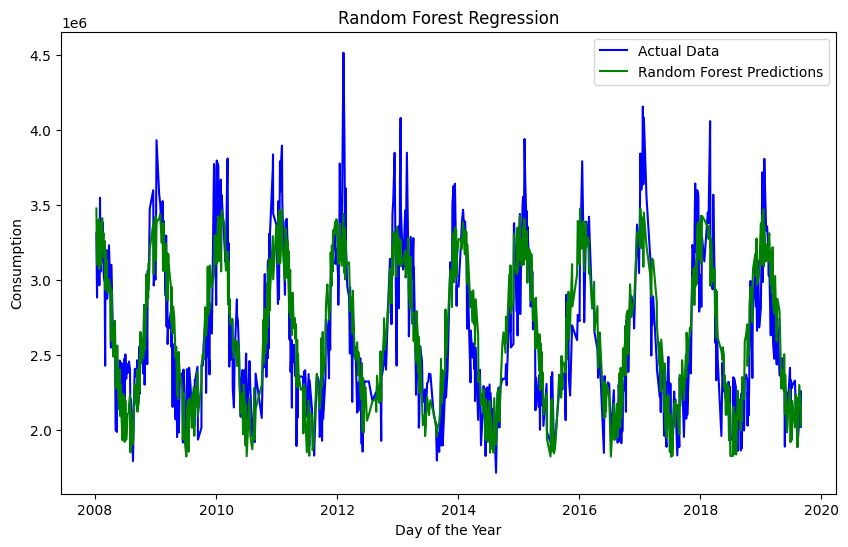

In [11]:
# Supposons que df contient la colonne Numero_jour
# Assure-toi que X_test et y_test ont le même index que df
X_graphe =X_test.copy()
X_graphe['Numero_jour'] = data.loc[X_graphe.index, 'jour']  # Réintègre Numero_jour dans X_graphe

# Crée un DataFrame pour le graphique
graph_data = pd.DataFrame({
    'Numero_jour': X_graphe['Numero_jour'],
    'Actual': y_test.values,
    'Prediction': RL['predictions']
})

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_jour', y='Actual', data=graph_data, color='blue', label='Actual Data', errorbar=None)
sns.lineplot(x='Numero_jour', y='Prediction', data=graph_data, color='green', label='Random Forest Predictions', errorbar=None)

plt.title('Random Forest Regression')
plt.xlabel("Day of the Year")
plt.ylabel('Consumption')
plt.legend()
plt.show()


Entrainement d'un random forest

In [12]:
forest = train_random_forest(X_train,y_train,X_test,y_test)

In [13]:
forest

{'model': RandomForestRegressor(random_state=42),
 'predictions': array([1852327.47394333, 1889736.614705  , 2729747.83829333,
        3489740.679665  , 3836664.11159   , 2302586.6535275 ,
        1862022.5728    , 2589115.12226333, 2063625.3389    ,
        2647449.75219   , 2403218.51385   , 3616245.18172   ,
        2374964.50976333, 2053923.24852683, 2453927.42998   ,
        2272051.1378    , 2302584.73109   , 2343651.84862   ,
        2935479.5493675 , 2656522.085585  , 2469185.01110834,
        2997522.55231   , 3326926.55701   , 2282973.28571   ,
        2343770.82357   , 2580611.29764   , 2247921.49530333,
        2137539.39267733, 1936984.13139   , 2494527.52578   ,
        2301818.01060667, 2097258.7453    , 2119080.31595   ,
        2817691.60950083, 3537474.53142   , 2278054.71122333,
        3117019.35581   , 3778463.85400833, 2161728.90247333,
        2710730.30857667, 2323841.05676333, 2522333.64567   ,
        2754672.37953   , 2622365.7313    , 2363761.08820333,
     

graphique des prédictions du modèle vs la réalité

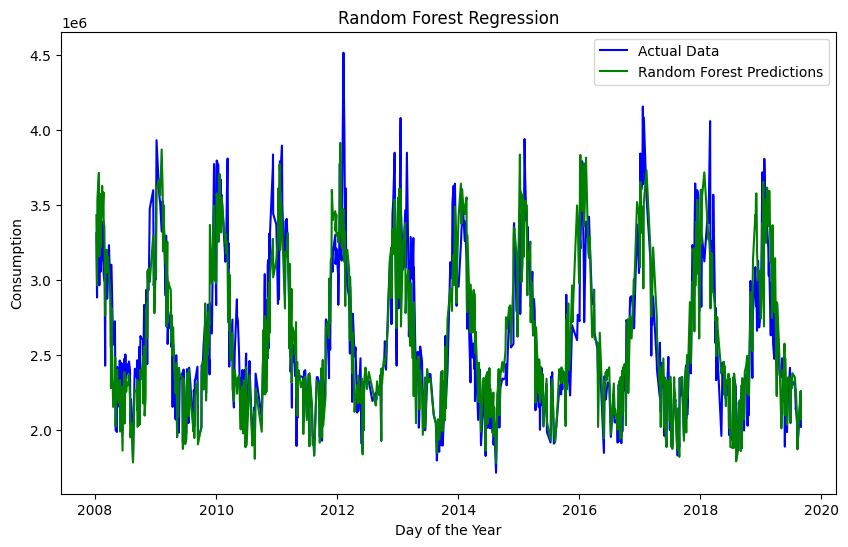

In [14]:
# Supposons que df contient la colonne Numero_jour
# Assure-toi que X_test et y_test ont le même index que df
X_graphe =X_test.copy()
X_graphe['Numero_jour'] = data.loc[X_graphe.index, 'jour']  # Réintègre Numero_jour dans X_graphe

# Crée un DataFrame pour le graphique
graph_data = pd.DataFrame({
    'Numero_jour': X_graphe['Numero_jour'],
    'Actual': y_test.values,
    'Prediction': forest['predictions']
})

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_jour', y='Actual', data=graph_data, color='blue', label='Actual Data', errorbar=None)
sns.lineplot(x='Numero_jour', y='Prediction', data=graph_data, color='green', label='Random Forest Predictions', errorbar=None)

plt.title('Random Forest Regression')
plt.xlabel("Day of the Year")
plt.ylabel('Consumption')
plt.legend()
plt.show()


Entrainement d'un XGBOOST 

In [15]:
XGB = train_xgboost(X_train,y_train,X_test,y_test)

In [16]:
XGB

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'predictions': array([2062725.2, 1923281.5, 2730987.2, 3558264. , 3496350.2, 2285351.8,
        1912044. , 2558472.8, 2112213.8, 2487980.8, 2327309.8, 3525715.5,
        2353453. , 2079193.8, 2441247.8, 2230215.2, 2328472.2, 2353166.2,
  

# Prévision sur des données du future

In [17]:
import pandas as pd

# Générer un DataFrame avec des dates futures
start_date = '2019-09-01'
end_date = '2020-12-31'  # Par exemple, une année entière
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Créer un DataFrame avec une colonne 'jour'
future_df = pd.DataFrame({'jour': future_dates})


In [18]:
# Ajouter les colonnes de jour/mois
future_df = extract_dayMonth(future_df, 'jour')

# Ajouter les caractéristiques supplémentaires
future_df = extract_features(future_df)

In [19]:
future_df.head(15)

,jour,Annee,sin_jour_annee,cos_jour_annee,sin_jour,cos_jour,sin_mois,cos_mois
0,2019-09-01,2019,-0.87,-0.49,-0.78,0.62,-1.00,-0.00
1,2019-09-02,2019,-0.88,-0.47,0.00,1.00,-1.00,-0.00
2,2019-09-03,2019,-0.89,-0.46,0.78,0.62,-1.00,-0.00
3,2019-09-04,2019,-0.90,-0.44,0.97,-0.22,-1.00,-0.00
4,2019-09-05,2019,-0.90,-0.43,0.43,-0.90,-1.00,-0.00
5,2019-09-06,2019,-0.91,-0.41,-0.43,-0.90,-1.00,-0.00
6,2019-09-07,2019,-0.92,-0.40,-0.97,-0.22,-1.00,-0.00
7,2019-09-08,2019,-0.92,-0.38,-0.78,0.62,-1.00,-0.00
8,2019-09-09,2019,-0.93,-0.37,0.00,1.00,-1.00,-0.00
9,2019-09-10,2019,-0.94,-0.35,0.78,0.62,-1.00,-0.00


In [20]:
# Sélectionner les colonnes utilisées pour l'entraînement
X_future = future_df[[ 'sin_jour_annee', 'cos_jour_annee', 'sin_jour', 'cos_jour', 'sin_mois', 'cos_mois']]
X_future = X_future[X_train.columns]

# Effectuer les prédictions
future_predictions = XGB['model'].predict(X_future)

# Ajouter les prédictions au DataFrame
future_df['consommation'] = future_predictions


In [21]:
future_df

,jour,Annee,sin_jour_annee,cos_jour_annee,sin_jour,cos_jour,sin_mois,cos_mois,consommation
0,2019-09-01,2019,-0.87,-0.49,-0.78,0.62,-1.00,-0.00,1919256.88
1,2019-09-02,2019,-0.88,-0.47,0.00,1.00,-1.00,-0.00,2254476.00
2,2019-09-03,2019,-0.89,-0.46,0.78,0.62,-1.00,-0.00,2314605.00
3,2019-09-04,2019,-0.90,-0.44,0.97,-0.22,-1.00,-0.00,2318981.75
4,2019-09-05,2019,-0.90,-0.43,0.43,-0.90,-1.00,-0.00,2318047.00
...,...,...,...,...,...,...,...,...,...
483,2020-12-27,2020,-0.07,1.00,-0.78,0.62,-0.00,1.00,2922454.50
484,2020-12-28,2020,-0.05,1.00,0.00,1.00,-0.00,1.00,3167478.75
485,2020-12-29,2020,-0.03,1.00,0.78,0.62,-0.00,1.00,3184934.75
486,2020-12-30,2020,-0.02,1.00,0.97,-0.22,-0.00,1.00,3151154.25


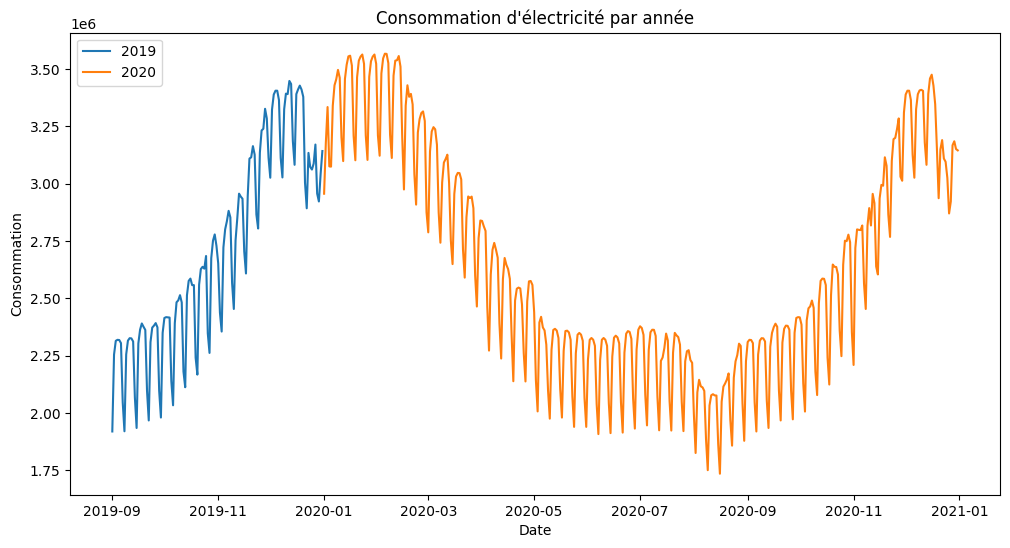

In [22]:
plot_consommation_par_annee(future_df)

In [23]:
future_df

,jour,Annee,sin_jour_annee,cos_jour_annee,sin_jour,cos_jour,sin_mois,cos_mois,consommation
0,2019-09-01,2019,-0.87,-0.49,-0.78,0.62,-1.00,-0.00,1919256.88
1,2019-09-02,2019,-0.88,-0.47,0.00,1.00,-1.00,-0.00,2254476.00
2,2019-09-03,2019,-0.89,-0.46,0.78,0.62,-1.00,-0.00,2314605.00
3,2019-09-04,2019,-0.90,-0.44,0.97,-0.22,-1.00,-0.00,2318981.75
4,2019-09-05,2019,-0.90,-0.43,0.43,-0.90,-1.00,-0.00,2318047.00
...,...,...,...,...,...,...,...,...,...
483,2020-12-27,2020,-0.07,1.00,-0.78,0.62,-0.00,1.00,2922454.50
484,2020-12-28,2020,-0.05,1.00,0.00,1.00,-0.00,1.00,3167478.75
485,2020-12-29,2020,-0.03,1.00,0.78,0.62,-0.00,1.00,3184934.75
486,2020-12-30,2020,-0.02,1.00,0.97,-0.22,-0.00,1.00,3151154.25


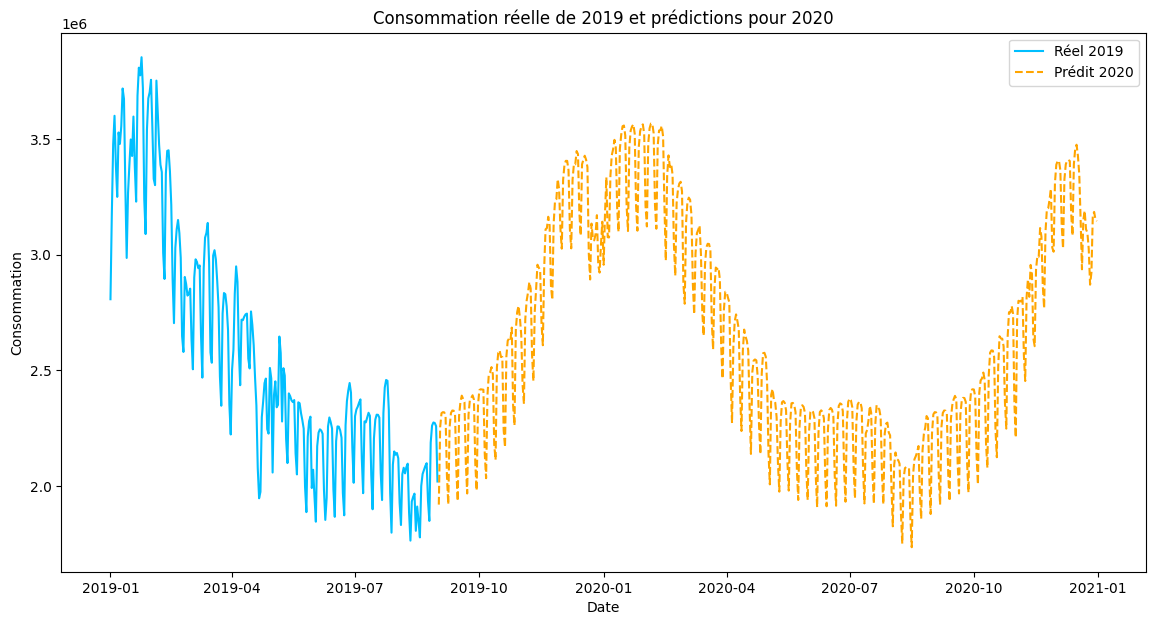

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supposons que vos données sont déjà chargées dans un DataFrame appelé `data`
# et que les prédictions pour 2020 sont dans un DataFrame appelé `future_df`

# Extraire les données de 2019 en utilisant la colonne `Annee`
data_2019 = data[data['Annee'] == 2019]

# Extraire les prédictions pour 2020
predictions_2020 = future_df

# Visualiser les résultats avec des couleurs différentes
plt.figure(figsize=(14, 7))

# Tracer les données réelles de 2019
plt.plot(data_2019['jour'], data_2019['consommation'], label='Réel 2019', color='deepskyblue')

# Tracer les prédictions pour 2020
plt.plot(predictions_2020['jour'], predictions_2020['consommation'], label='Prédit 2020', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.title('Consommation réelle de 2019 et prédictions pour 2020')
plt.legend()
plt.show()


# MLFLOW TRACKING

In [92]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature

In [93]:
import dagshub
dagshub.init(repo_owner='kadermamoudou88', repo_name='MLOPS-project', mlflow=True)

Initialized MLflow to track repo "kadermamoudou88/MLOPS-project"

Repository kadermamoudou88/MLOPS-project initialized!

In [94]:
# Configuration des variables d'environnement pour l'authentification avec le serveur MLflow hébergé sur DagsHub.
# MLFLOW_TRACKING_USERNAME : Nom d'utilisateur pour DagsHub.
# MLFLOW_TRACKING_PASSWORD : Token d'accès pour authentification sécurisée.
# MLFLOW_TRACKING_URI : URI du serveur distant MLflow pour le suivi des expérimentations.
import os 
os.environ['MLFLOW_TRACKING_USERNAME'] = 'kadermamoudou88'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cdc80ad9f32ee76bc2993288b2b6402b2b88f646'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow'

In [96]:
# Configuration de l'expérience MLflow
mlflow.set_experiment("Energy forecasting")
mlflow.set_tracking_uri('https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow')
# Liste des modèles
models = [
    ("Linear Regression", RL),
    ("Random Forest", forest),
    ("XGBoost", XGB),
]

for model_name, model_dict in models:
    model = model_dict["model"]
    y_pred = model_dict["predictions"]
    mse = model_dict["mse"]
    r2 = model_dict["r2"]

    # Journalisation avec MLflow
    input_example = X_train.head(1).to_dict(orient="list")
    with mlflow.start_run(run_name=model_name):
        mlflow.log_metrics({"mse": mse, "r2": r2})

        if model_name == "XGBoost":
            mlflow.xgboost.log_model(
                model, "model",
                input_example=input_example,
                signature=infer_signature(X_train, y_train)
            )
        else:
            mlflow.sklearn.log_model(
                model, "model",
                input_example=input_example,
                signature=infer_signature(X_train, y_train)
            )

2024/12/20 05:13:38 INFO mlflow.tracking.fluent: Experiment with name 'Energy forecasting' does not exist. Creating a new experiment.


🏃 View run Linear Regression at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/2fe4a6cc3a1a47cba99407c1a50bf99f
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


🏃 View run Random Forest at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/881c78848fe647b19331555138510e55
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/12/20 05:14:27 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
TypeError("Not supported type for data.<class 'dict'>")Traceback (most recent call last):


  File "c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\utils\_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "c:\Users\derka\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\xgboost\__init__.py", line 376

🏃 View run XGBoost at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1/runs/d2f1b767516d40d08e364763aae4d8d8
🧪 View experiment at: https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1


lien vers notre MLFLOW : https://dagshub.com/kadermamoudou88/MLOPS-project.mlflow/#/experiments/1?viewStateShareKey=d537fdc0c959fa49a2e0b67727b54010fcd4ffd194d195a2598ac3fdf5c6e596